# Classify Sentinel-1 data using Sentinel-2 data

## Load packages

In [1]:
%matplotlib inline

import sys
sys.path.insert(1, '../Tools/')

import os
import datacube
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import nearest_points

from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.coastal import model_tides, tidal_tag, pixel_tides, tidal_stats
from deafrica_tools.spatial import subpixel_contours
# from dea_tools.coastal import model_tides, tidal_tag, pixel_tides, tidal_stats
# from dea_tools.spatial import subpixel_contours
from deafrica_tools.plotting import display_map, rgb, map_shapefile
from deafrica_tools.dask import create_local_dask_cluster
from coastlines.raster import tide_cutoffs,load_tidal_subset
from coastlines.vector import points_on_line, annual_movements, calculate_regressions

from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from skimage.filters import threshold_minimum, threshold_otsu
from datacube.utils.cog import write_cog

import itertools
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,cohen_kappa_score,confusion_matrix,ConfusionMatrixDisplay,balanced_accuracy_score
from deafrica_tools.classification import predict_xr

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


## Set up a Dask cluster

In [2]:
client = create_local_dask_cluster(return_client=True)

<Client: 'tcp://127.0.0.1:42745' processes=1 threads=15, memory=104.37 GB>

### Connect to the datacube

In [3]:
dc = datacube.Datacube(app="Sentinel-1 land water classification")

In [4]:
# Define the area of interest: Madagarscar
lat = -17.474
lon = 43.924

# Define the area of interest: around Comoros
# lat = -12.4
# lon = 43.736

# Combine central lat,lon with buffer to get area of interest
buffer = 0.04
lat_range = (lat - buffer, lat + buffer)
lon_range = (lon - buffer, lon + buffer)

# Set the range of dates for the analysis, time step and tide range
time_range = ('2018', '2021')
time_step = '1Y'
tide_range = (0.25, 0.75)

# whether to implement Lee filtering on Sentinel-1 data
lee_filtering=True

# Lee filtering size
filter_size=2

## View the selected location

In [5]:
display_map(x=lon_range, y=lat_range)

## Load Sentinel-1 data

In [6]:
# Create the 'query' dictionary object, which contains the longitudes,
# latitudes and time provided above
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': ['vh','vv','mask','area'], # loading vh for experiement
    'resolution': (-20, 20),
}
# Identify the most common projection system in the input query
output_crs = "EPSG:6933" #mostcommon_crs(dc=dc, product='s2_l2a', query=query)

In [7]:
S1_ascending=load_ard(dc=dc,
              products=['s1_rtc'],
              output_crs=output_crs,
              resampling='bilinear',
              align=(10, 10),
              #mask_filters=[("opening", 2), ("dilation", 5)],
              dask_chunks={'time': 1},
              group_by='solar_day',
              dtype='native',
              sat_orbit_state='ascending',
              **query)
S1_descending=load_ard(dc=dc,
              products=['s1_rtc'],
              output_crs=output_crs,
              resampling='bilinear',
              align=(10, 10),
              #mask_filters=[("opening", 2), ("dilation", 5)],
              dask_chunks={'time': 1},
              group_by='solar_day',
              dtype='native',
              sat_orbit_state='descending',
              **query)
print('ascending observations:\n',S1_ascending)
print('descending observations:\n',S1_descending)

Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 1 time steps as a dask array
Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 145 time steps as a dask array
ascending observations:
 <xarray.Dataset>
Dimensions:      (time: 1, y: 489, x: 387)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-16T15:35:17.204160
  * y            (y) float64 -2.191e+06 -2.191e+06 ... -2.201e+06 -2.201e+06
  * x            (x) float64 4.234e+06 4.234e+06 ... 4.242e+06 4.242e+06
    spatial_ref  int32 6933
Data variables:
    vh           (time, y, x) float32 dask.array<chunksize=(1, 489, 387), meta=np.ndarray>
    vv           (time, y, x) float32 dask.array<chunksize=(1, 489, 387), meta=np.ndarray>
    mask         (time, y, x) uint8 dask.array<chunksize=(1, 489, 387), meta=np.ndarray>
    area         (time, y, x) float32 dask.array<chunksize=(1, 489, 387), m

In [8]:
S1_ascending["isAscending"] = S1_ascending.mask.groupby("time").apply(lambda da: xr.where(da!=0,1,np.nan))
S1_ascending["isDescending"] = S1_ascending.mask.groupby("time").apply(lambda da: xr.where(da!=0,0,np.nan))
S1_descending["isAscending"] = S1_descending.mask.groupby("time").apply(lambda da: xr.where(da!=0,0,np.nan))
S1_descending["isDescending"] = S1_descending.mask.groupby("time").apply(lambda da: xr.where(da!=0,1,np.nan))

S1=xr.concat([S1_ascending,S1_descending],dim='time')
ascending_mask=(S1.isAscending.sum(dim='time')>S1.isDescending.sum(dim='time'))
descending_mask=(S1.isAscending.sum(dim='time')<=S1.isDescending.sum(dim='time'))
S1=S1.where((ascending_mask&(S1.isAscending==1))|(descending_mask&(S1.isDescending==1)),np.nan)
# drop all-nan observations
S1=S1.dropna(dim='time',how='all')
print(S1)

<xarray.Dataset>
Dimensions:       (time: 145, y: 489, x: 387)
Coordinates:
  * time          (time) datetime64[ns] 2018-01-10T02:35:29.430322 ... 2021-1...
  * y             (y) float64 -2.191e+06 -2.191e+06 ... -2.201e+06 -2.201e+06
  * x             (x) float64 4.234e+06 4.234e+06 ... 4.242e+06 4.242e+06
    spatial_ref   int32 6933
Data variables:
    vh            (time, y, x) float32 dask.array<chunksize=(1, 489, 387), meta=np.ndarray>
    vv            (time, y, x) float32 dask.array<chunksize=(1, 489, 387), meta=np.ndarray>
    mask          (time, y, x) float64 dask.array<chunksize=(1, 489, 387), meta=np.ndarray>
    area          (time, y, x) float32 dask.array<chunksize=(1, 489, 387), meta=np.ndarray>
    isAscending   (time, y, x) float64 dask.array<chunksize=(1, 489, 387), meta=np.ndarray>
    isDescending  (time, y, x) float64 dask.array<chunksize=(1, 489, 387), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


## Load Sentinel-2 data

In [9]:
query_s2 = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': ['red', 'green', 'blue', 'swir_1','nir'],
    'resolution': (-20, 20),
}
S2 = load_ard(dc=dc,
              products=['s2_l2a'],
              output_crs=output_crs,
              resampling='bilinear',
              min_gooddata=0.6,
              align=(10, 10),
              mask_filters=[("opening", 2), ("dilation", 5)],
              dask_chunks={'time': 1},
              group_by='solar_day',
              **query_s2)
# Calculate the water index
S2 = calculate_indices(S2, index='MNDWI', satellite_mission='s2')
print(S2)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 220 out of 288 time steps with at least 60.0% good quality pixels
Applying morphological filters to pq mask [('opening', 2), ('dilation', 5)]
Applying pixel quality/cloud mask
Returning 220 time steps as a dask array


## Tide modelling and filtering

In [11]:
# per-pixel tide modelling
S1["tide_m"], tides_lowres = pixel_tides(S1, resample=True)

# Determine tide cutoff
tide_cutoff_min_s1, tide_cutoff_max_s1 = tide_cutoffs(
    S1, tides_lowres, tide_centre=0.0
)

# Filter observations using calculated tide cutoffs  
tide_bool_s1 = (S1.tide_m >= tide_cutoff_min_s1) & (
    S1.tide_m <= tide_cutoff_max_s1
)
S1_filtered = S1.sel(time=tide_bool_s1.sum(dim=["x", "y"]) > 0)
# Apply mask, and load in corresponding tide masked data
S1_filtered = S1_filtered.where(tide_bool_s1)
print(S1_filtered)


Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 145/145 [00:00<00:00, 219.59it/s]


<xarray.Dataset>
Dimensions:       (time: 75, y: 489, x: 387)
Coordinates:
  * time          (time) datetime64[ns] 2018-01-10T02:35:29.430322 ... 2021-1...
  * y             (y) float64 -2.191e+06 -2.191e+06 ... -2.201e+06 -2.201e+06
  * x             (x) float64 4.234e+06 4.234e+06 ... 4.242e+06 4.242e+06
    spatial_ref   int32 6933
Data variables:
    vh            (time, y, x) float32 dask.array<chunksize=(1, 489, 387), meta=np.ndarray>
    vv            (time, y, x) float32 dask.array<chunksize=(1, 489, 387), meta=np.ndarray>
    mask          (time, y, x) float64 dask.array<chunksize=(1, 489, 387), meta=np.ndarray>
    area          (time, y, x) float32 dask.array<chunksize=(1, 489, 387), meta=np.ndarray>
    isAscending   (time, y, x) float64 dask.array<chunksize=(1, 489, 387), meta=np.ndarray>
    isDescending  (time, y, x) float64 dask.array<chunksize=(1, 489, 387), meta=np.ndarray>
    tide_m        (time, y, x) float32 -0.7489 -0.7489 -0.749 ... 0.332 0.3321
Attributes:
    

In [13]:
# per-pixel tide modelling
S2["tide_m"], tides_lowres = pixel_tides(S2, resample=True)

# Determine tide cutoff
tide_cutoff_min_s2, tide_cutoff_max_s2 = tide_cutoffs(
    S2, tides_lowres, tide_centre=0.0
)

# Filter observations using calculated tide cutoffs  
tide_bool_s2 = (S2.tide_m >= tide_cutoff_min_s2) & (
    S2.tide_m <= tide_cutoff_max_s2
)
S2_filtered = S2.sel(time=tide_bool_s2.sum(dim=["x", "y"]) > 0)

# Apply mask, and load in corresponding tide masked data
S2_filtered = S2_filtered.where(tide_bool_s2)
print(S2_filtered)

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 220/220 [00:00<00:00, 362.23it/s]


<xarray.Dataset>
Dimensions:      (time: 114, y: 489, x: 387)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-22T07:22:04 ... 2021-12-22T07:...
  * y            (y) float64 -2.191e+06 -2.191e+06 ... -2.201e+06 -2.201e+06
  * x            (x) float64 4.234e+06 4.234e+06 ... 4.242e+06 4.242e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 489, 387), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 489, 387), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 489, 387), meta=np.ndarray>
    swir_1       (time, y, x) float32 dask.array<chunksize=(1, 489, 387), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 489, 387), meta=np.ndarray>
    MNDWI        (time, y, x) float32 dask.array<chunksize=(1, 489, 387), meta=np.ndarray>
    tide_m       (time, y, x) float32 0.3614 0.3614 0.3614 ... -0.7465 -0.7465
Attributes:
    crs:     

## Preprocess Sentinel-1

In [14]:
# covert to db
S1_filtered['vh']=10 * xr.ufuncs.log10(S1_filtered.vh)
S1_filtered['vv']=10 * xr.ufuncs.log10(S1_filtered.vv)

In [15]:
# features calculation
S1_filtered['vv_a_vh']=S1_filtered['vv']+S1_filtered['vh']
S1_filtered['vv_m_vh']=S1_filtered['vv']-S1_filtered['vh']

### Calculate temporal composites

In [16]:
ds_summaries_s1 = (S1_filtered[['vh','vv','vv_a_vh','vv_m_vh','area']]
                     .resample(time=time_step)
                     .median('time')
                     .compute()
                    )
ds_summaries_s2 = (S2_filtered[['MNDWI']]
                .resample(time=time_step)
                .median('time')
                .compute()
                    )
print(ds_summaries_s1)
print(ds_summaries_s2)

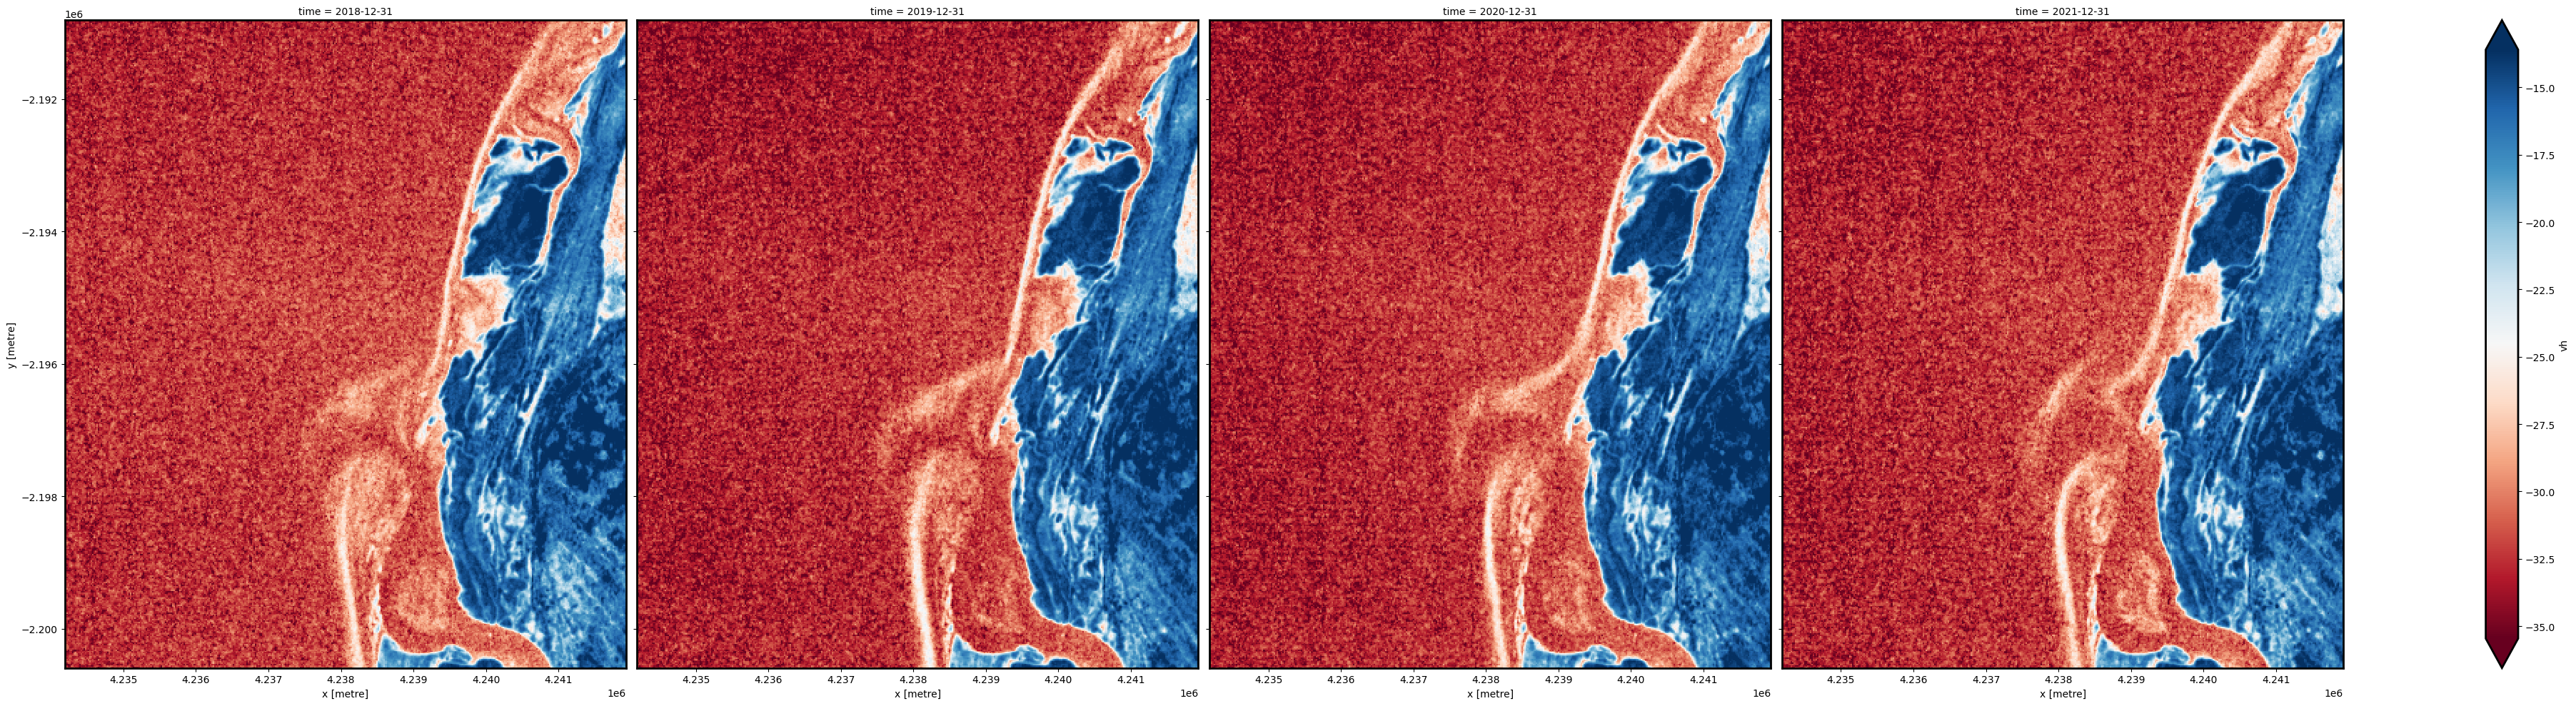

In [27]:
# Plot the output summary images
ds_summaries_s1.vh.plot(
                        col='time',
                       cmap='RdBu',
                       col_wrap=4,
                       robust=True, size=10)
plt.show()

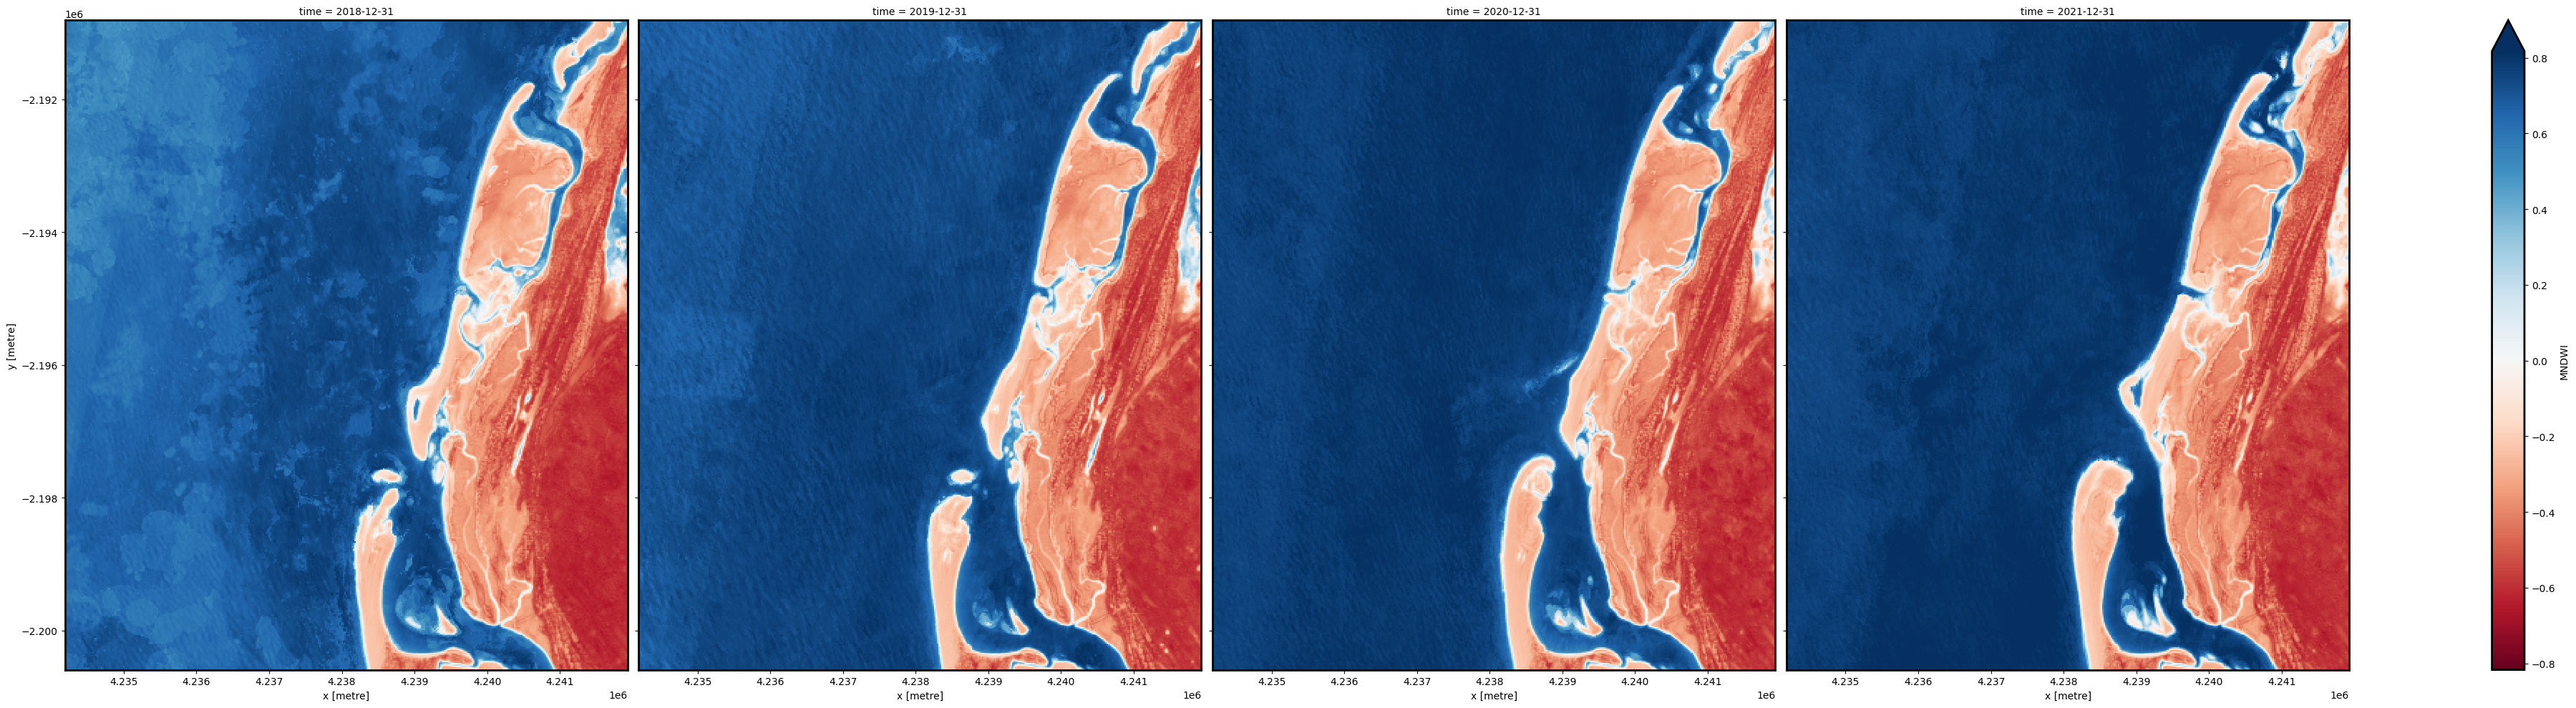

In [28]:
# Plot the output summary images
ds_summaries_s2.MNDWI.plot(
                        col='time',
                       cmap='RdBu',
                       col_wrap=4,
                       robust=True, size=10)
plt.show()

## Build classifier

### Generate training pixels using Sentinel-2 data

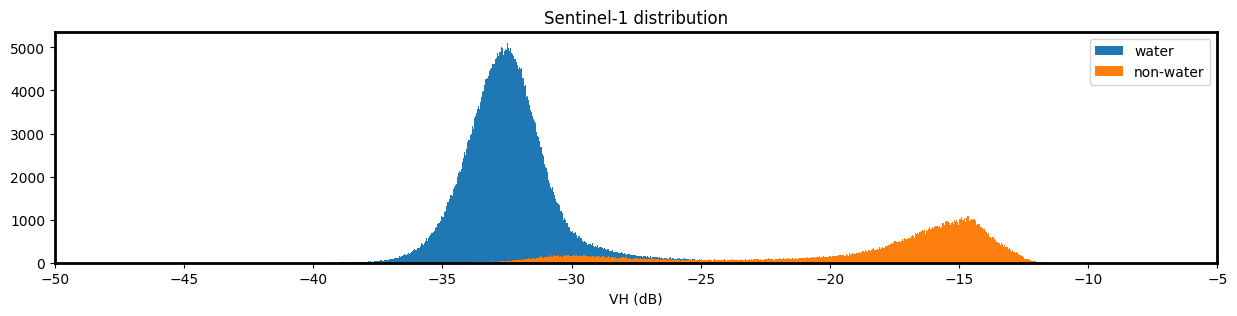

In [19]:
fig, ax = plt.subplots(figsize=(15, 3))
plt.xlim(-50,-5)
ds_summaries_s1['vh'].where(ds_summaries_s2['MNDWI']>0.1).plot.hist(bins=1000, label="water")
ds_summaries_s1['vh'].where(ds_summaries_s2['MNDWI']<=0.1).plot.hist(bins=1000, label="non-water")
plt.legend()
plt.xlabel("VH (dB)")
plt.title("Sentinel-1 distribution")
plt.show()

In [24]:
# classs: water (1) and non-water (0)
ds_summaries_s2['water']=ds_summaries_s2['MNDWI']>0.1
s1_data=ds_summaries_s1.to_array(dim='variable').transpose('x','y','time', 'variable').values
data_shape = s1_data.shape
data=s1_data.reshape(data_shape[0]*data_shape[1]*data_shape[2],data_shape[3])
labels=ds_summaries_s2.water.transpose('x','y','time').values.reshape(data_shape[0]*data_shape[1]*data_shape[2],)
print(data.shape)
print(labels.shape)

[[-34.73514    -19.748634   -56.791756     0.54640675   1.2103833 ]
 [-35.01678    -18.884714   -53.817005     0.5087421    1.2094886 ]
 [-32.521458   -19.124605   -52.30329      0.5787832    1.2108151 ]
 ...
 [-16.989958   -10.837553   -27.851936     0.6562629    1.1764    ]
 [-16.677593   -11.203486   -27.642778     0.70614004   1.1767495 ]
 [-17.309048   -11.375699   -28.759264     0.6352984    1.1764175 ]]
[ True  True  True ... False False False]


### Fit a random forest model

In [36]:
rf=RandomForestClassifier(n_estimators=200,max_samples=0.5,min_samples_leaf=1,bootstrap=True)
rf.fit(data,labels)

RandomForestClassifier(max_samples=0.5, n_estimators=200)

Text(0.5, 0, 'Variable')

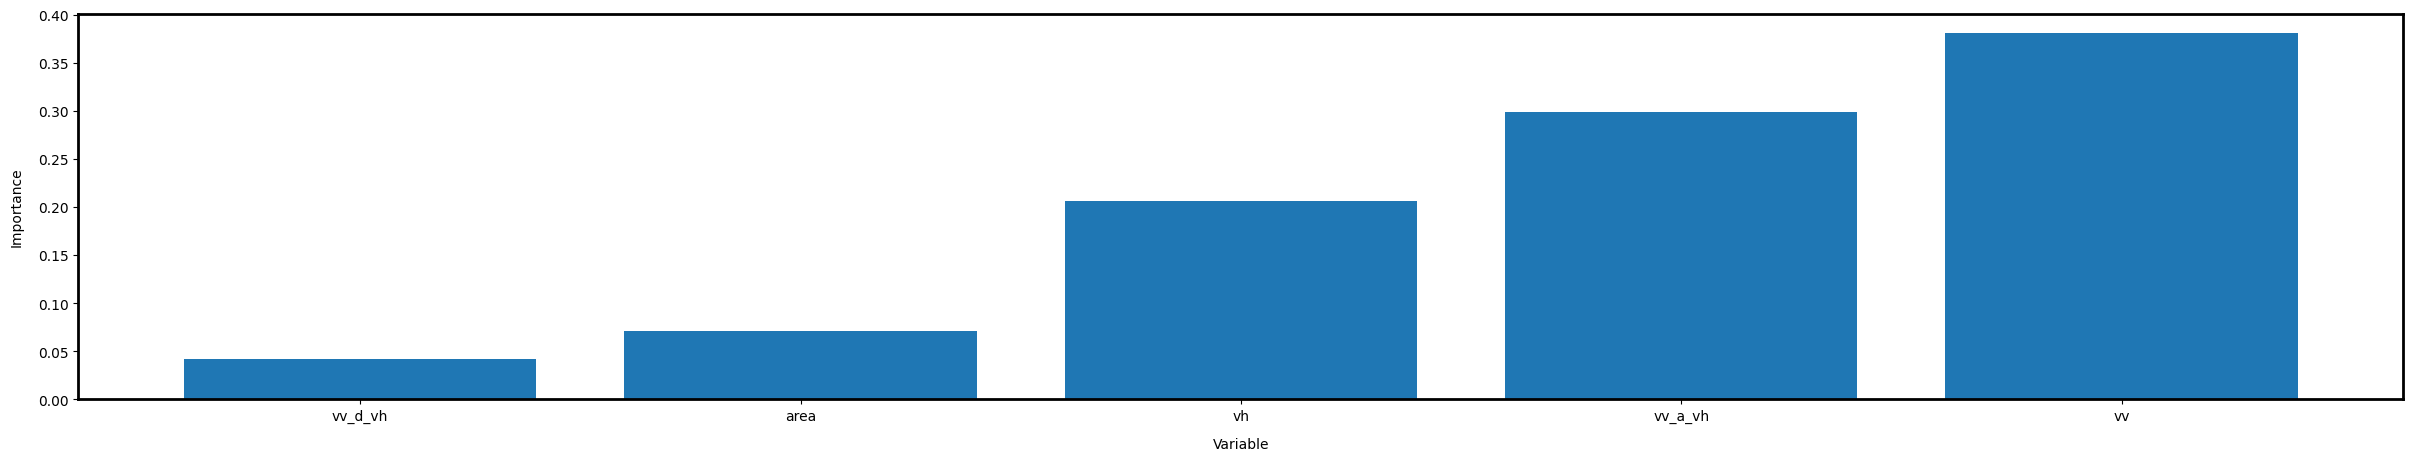

In [40]:
plt.figure(figsize=(30,5))
order=np.argsort(rf.feature_importances_)
plt.bar(x=np.array(list(ds_summaries_s1.keys()))[order],height=rf.feature_importances_[order])
plt.gca().set_ylabel('Importance', labelpad=10)
plt.gca().set_xlabel('Variable', labelpad=10)

Overall accuracy from cv scores:  0.9630025930691973
Confusion matrix:



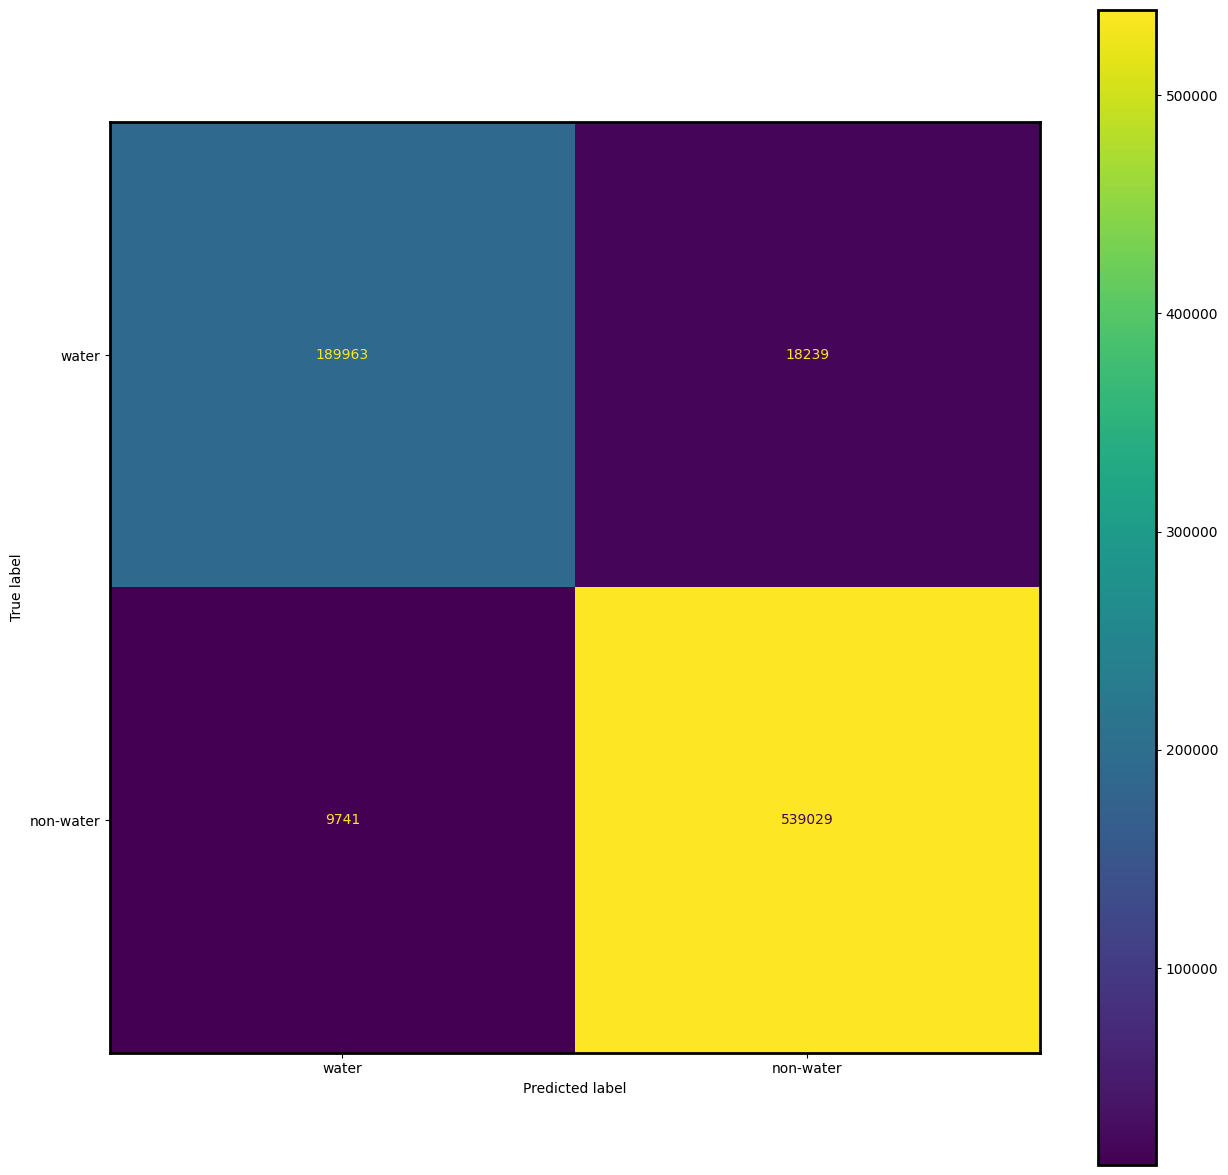

In [43]:
skf=model_selection.StratifiedKFold(n_splits=5,shuffle=True,random_state=1) # stratified K-fold splitting
overall_acc=model_selection.cross_val_score(rf,data,labels,cv=skf,scoring='accuracy')
print('Overall accuracy from cv scores: ',np.mean(overall_acc))

predictions=model_selection.cross_val_predict(rf,data,labels,cv=skf)
cm=confusion_matrix(labels, predictions)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['water','non-water'])
print('Confusion matrix:\n')
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)

## Apply the model

In [67]:
# Rename each image by year
ds_summaries_s1['time'] = ds_summaries_s1.time.dt.year
ds_summaries_s1 = ds_summaries_s1.rename(time='year')

In [68]:
# apply to each year
predicted=[]
for i in range(ds_summaries_s1.dims['year']):
    ds_s1_year=ds_summaries_s1.isel(year=i)
    predicted_year = predict_xr(rf,ds_s1_year,proba=True,persist=False,clean=True).assign_coords(year=ds_s1_year.year.values).expand_dims('year')
    predicted.append(predicted_year)
predicted=xr.concat(predicted,dim='year')
print(predicted)

predicting...
   probabilities...
predicting...
   probabilities...
predicting...
   probabilities...
predicting...
   probabilities...
<xarray.Dataset>
Dimensions:        (x: 387, y: 489, year: 4)
Coordinates:
  * x              (x) float64 4.234e+06 4.234e+06 ... 4.242e+06 4.242e+06
  * y              (y) float64 -2.191e+06 -2.191e+06 ... -2.201e+06 -2.201e+06
    spatial_ref    int32 6933
  * year           (year) int64 2018 2019 2020 2021
Data variables:
    Predictions    (year, y, x) int64 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0
    Probabilities  (year, y, x) float64 100.0 100.0 100.0 ... 99.5 100.0 100.0
Attributes:
    grid_mapping:  spatial_ref


### Plot predictions and probabilities

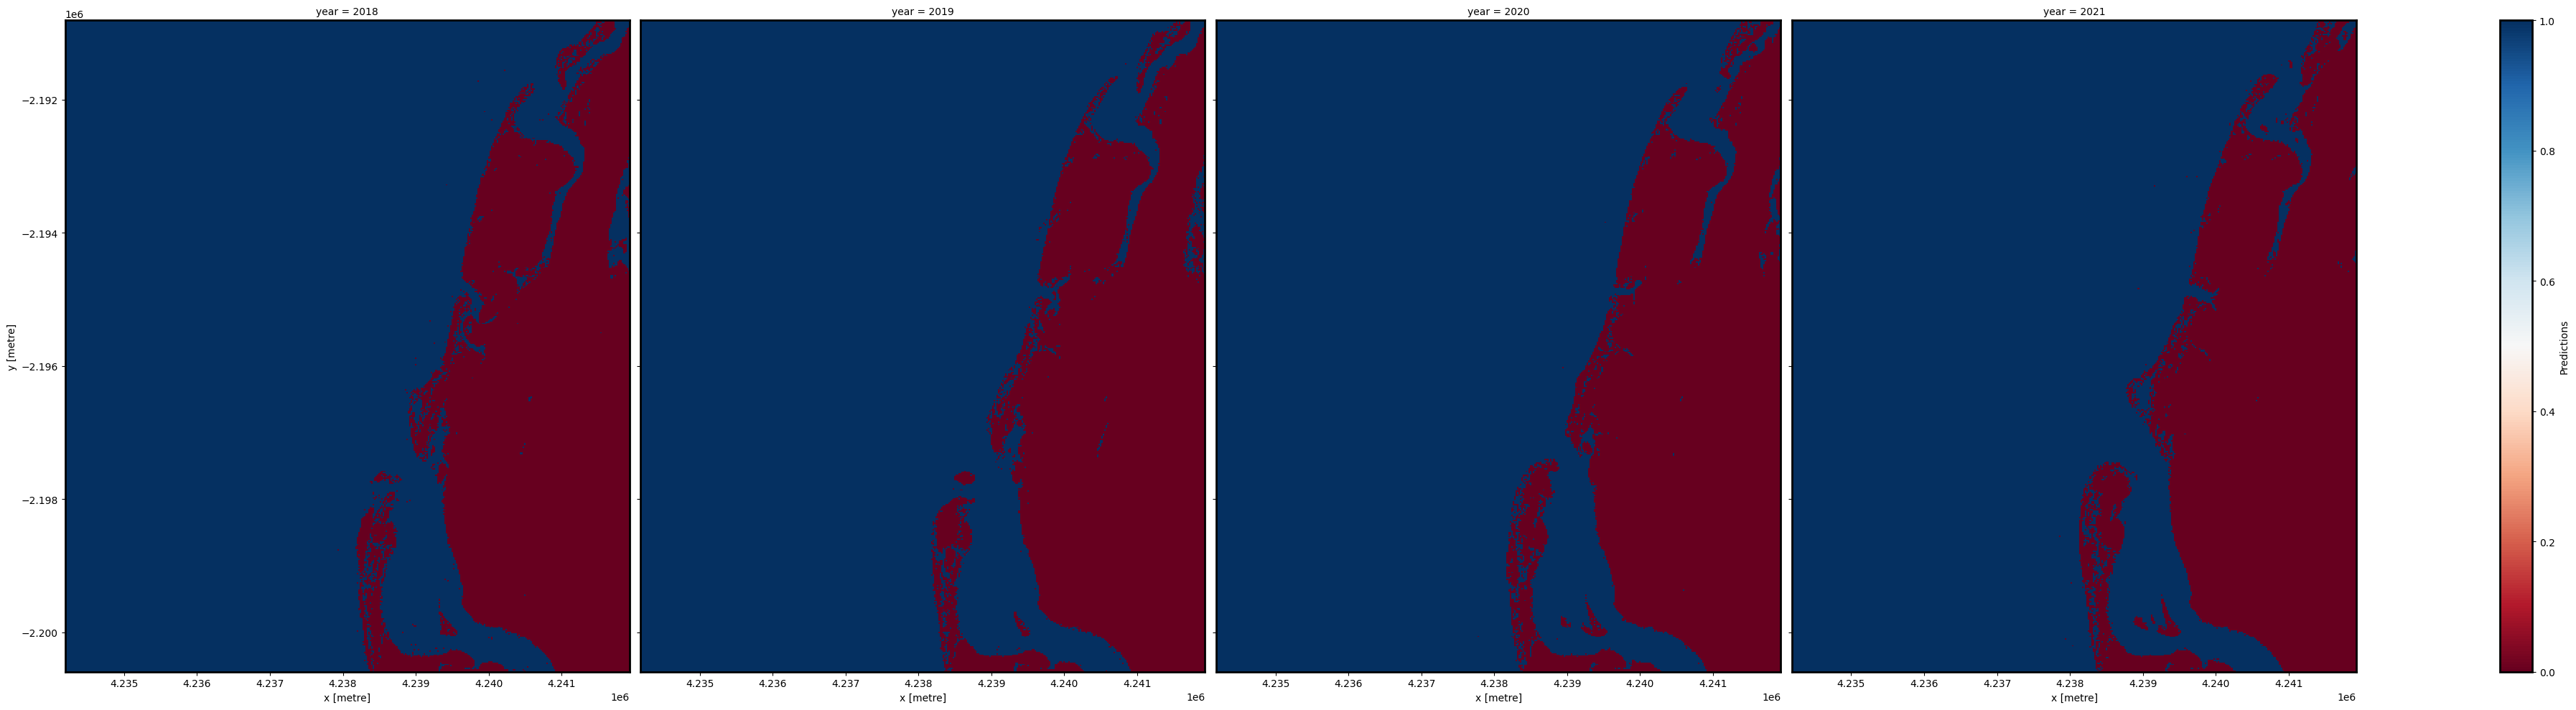

In [70]:
predicted.Predictions.plot(col='year',
                           cmap='RdBu',
                           col_wrap=4,
                           robust=True, 
                           size=10)

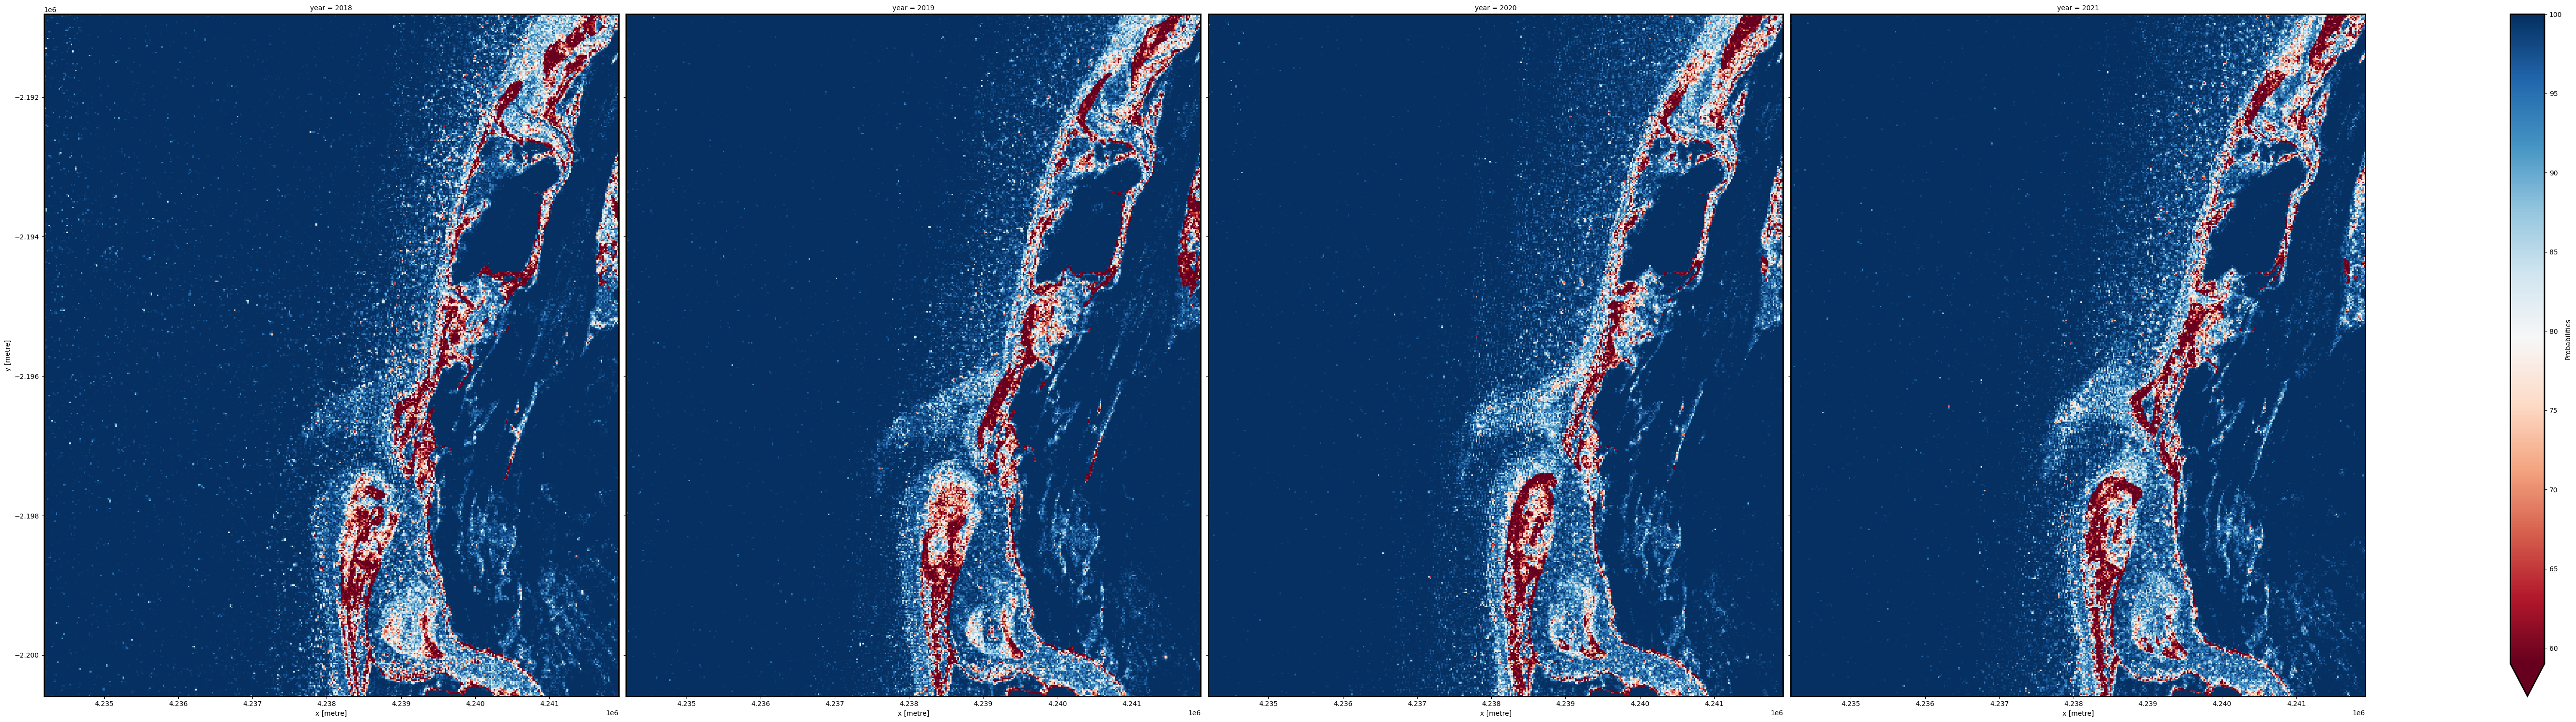

In [72]:
predicted.Probabilities.plot(col='year',
                           cmap='RdBu',
                           col_wrap=4,
                           robust=True, 
                           size=10)

## Extract shorelines

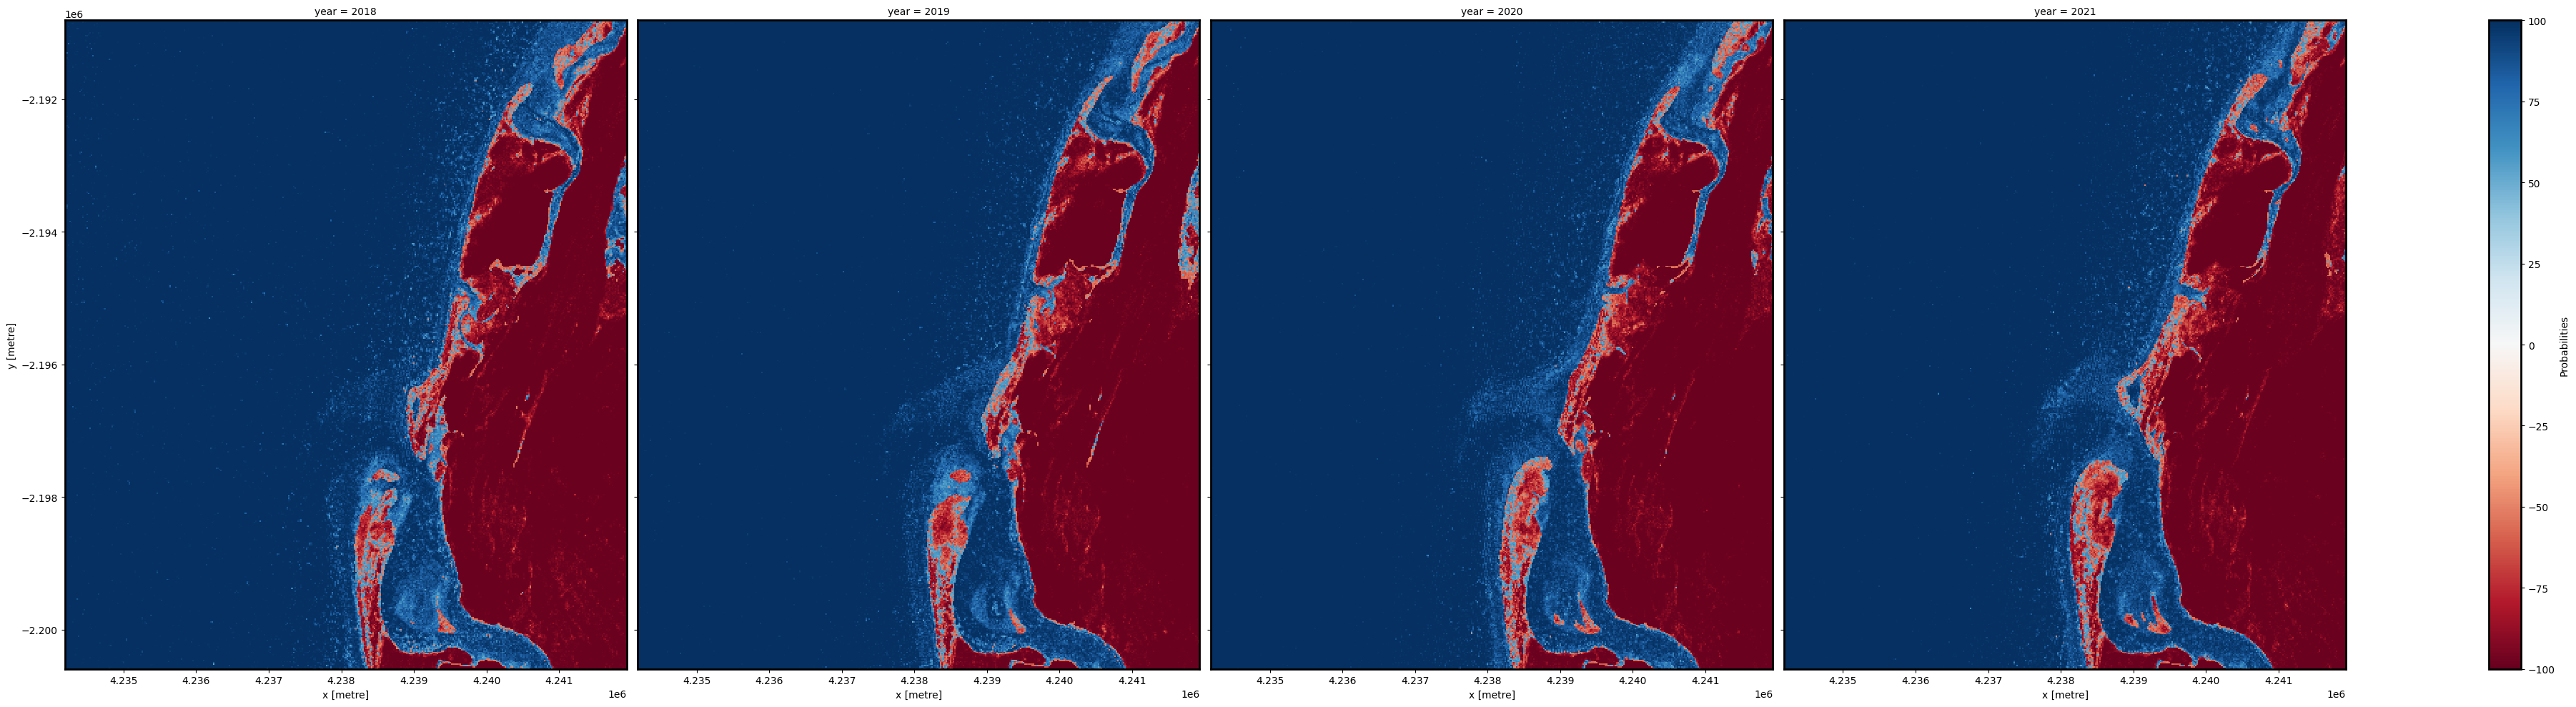

In [73]:
# covert the overall classification probabilities to water probabilities
predicted['Probabilities']=predicted.Probabilities.where(predicted.Predictions==1,1-predicted.Probabilities)
predicted.Probabilities.plot(col='year',
                           cmap='RdBu',
                           col_wrap=4,
                           robust=True, 
                           size=10)

In [74]:
# Extract waterline contours for the '0.5' probability:
contour_gdf = subpixel_contours(da=predicted.Probabilities,
                                z_values=0.5,
                                dim='year',
                                crs=predicted.geobox.crs,
                                affine=predicted.geobox.transform,
                                output_path=f'annual_shorelines_S1_supervised.geojson',
                                min_vertices=15).set_index('year')

### Plot annual shorelines on an interactive map

In [75]:
# Plot shorelines on interactive map
contour_gdf.reset_index().explore(
    column='year',
    cmap='inferno',
    tiles=
    'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='ESRI WorldImagery')